In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tqdm
import numpy as np
import torch
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from functorch import vmap, grad, make_functional

In [3]:
import matplotlib.pyplot as plt

def plot_image_and_patch(image, patch, slice_, ax=None):
    """
    image: [C, H, W]
    patch: [C, h, w]
    """
    assert image.shape[0] == 1
    if ax is None:
        fig, ax = plt.subplots()
    ax.axis('off')
    ax.matshow(image[0], cmap="gray_r")
    patch_with_mask = np.ones_like(image) * np.nan
    patch_with_mask[slice_] = patch
    ax.imshow(patch_with_mask[0], cmap='Reds', alpha=.8)


def plot_image_grid(images, patches=None, slice_=None):
    """
    images: [N, 1, C, H]
    """
    n = int(len(images) ** .5)
    fig, axes = plt.subplots(n, n, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        if patches is None:
            ax.imshow(images[i][0].cpu(), cmap='gray_r')
        elif patches is not None and slice_ is not None:
            plot_image_and_patch(images[i].cpu(), patches[i].cpu(), slice_, ax)
        ax.axis('off')
    # plt.tight_layout()
    return fig, axes

In [4]:

# Define a transform to convert images to tensor and normalize them to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset for training
batch_size = 64
train_dataset = MNIST(root='../data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

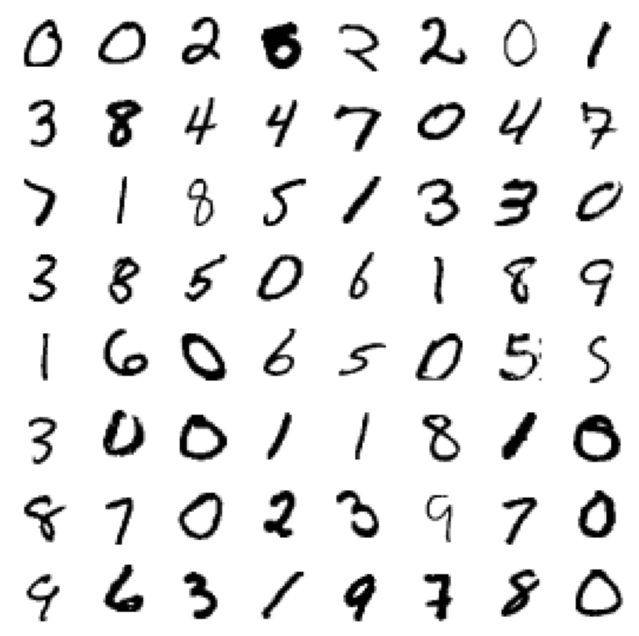

In [5]:

# Plot data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch = next(iter(train_loader))
images = batch[0].to(device)

plot_image_grid(images.cpu());

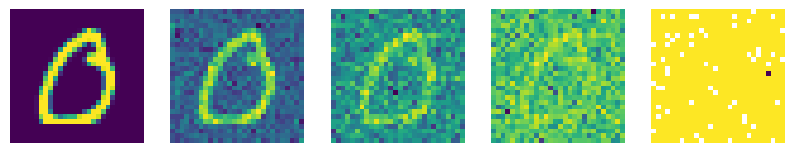

In [6]:
# Initialize network
from image_diffusion.sampling import euler_maruyama_integrate_loop

from image_diffusion.sde_diffusion import VPSDE, DDPM
# diffusion = VPSDE()
# N = 1000
diffusion = DDPM(100).to_(device)
N = diffusion.Ns
x, xs = euler_maruyama_integrate_loop(
    drift=diffusion.drift,
    diffusion=diffusion.diffusion,
    x0=images,
    ts=torch.linspace(diffusion.tmin, diffusion.tmax, N, device=device)
)

# indices = [0, 10, 25, 50, 99, 500, 999]
indices = [0, 10, 25, 50, 99]
fig, axes = plt.subplots(1, len(indices), figsize=(10, 3))
for i, ax in enumerate(axes):
    axes[i].imshow(xs[indices[i], 0, 0].cpu())
    axes[i].axis('off')

In [7]:
from image_diffusion.unet import create_model
model = create_model(
    image_size=28,
    in_channels=1,
    out_channels=1,
    # num_classes=None,  # no class conditioning
    num_channels=32,
    num_res_blocks=1,
    channel_mult="1, 2, 2",
    resblock_updown=True,
    model_path=os.path.join(os.getcwd(), "../", "experiments", "weights", "mnist_ddpm_unconditional.pth")
    # model_path=os.getcwd() + "/weights/unet_mnist_score.pth"
).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params / 1e6:.2f}M")

Loaded /homes/ebm32/protein-diffusion/notebooks/../experiments/weights/mnist_ddpm_unconditional.pth successfully.
Number of parameters: 1.23M


In [8]:
from image_diffusion.sde_diffusion import get_loss_fn, get_score_fn, DDPM, get_ddpm_loss_fn
from image_diffusion.likelihoods import get_likelihood
from image_diffusion.conditioning import get_conditioning

# score_fn = get_score_fn(model, diffusion)
# loss_fn = get_loss_fn(score_fn, diffusion)
# loss_fn(batch[0].to(device))
likelihood = get_likelihood("inpainting")(patch_size=14)
conditioning = get_conditioning("reconstruction")
loss_fn, eps_model = get_ddpm_loss_fn(model, diffusion, conditioning, likelihood)

Conditioning: Reconstruction


In [9]:
@torch.no_grad()
def sample(xT, y):
    # xT = torch.randn(size=(num, *image_size), device=device)
    x0_model = diffusion.get_x0_model(eps_model, conditioning)
    return diffusion.p_sample_loop(x0_model, xT)

def sample_prior():
    y = likelihood.none_like(images)
    xT = torch.randn_like(images)
    x0 = sample(xT, y)
    return x0

# NOTE: only for amortised model!
def sample_conditional():
    y = likelihood.forward(images)
    xT = torch.randn_like(images)
    x0 = sample(xT, y)
    return x0, y

In [10]:
ts = torch.linspace(1., 0., 100)
torch.stack([ts[:-1], ts[1:]], -1)

tensor([[1.0000, 0.9899],
        [0.9899, 0.9798],
        [0.9798, 0.9697],
        [0.9697, 0.9596],
        [0.9596, 0.9495],
        [0.9495, 0.9394],
        [0.9394, 0.9293],
        [0.9293, 0.9192],
        [0.9192, 0.9091],
        [0.9091, 0.8990],
        [0.8990, 0.8889],
        [0.8889, 0.8788],
        [0.8788, 0.8687],
        [0.8687, 0.8586],
        [0.8586, 0.8485],
        [0.8485, 0.8384],
        [0.8384, 0.8283],
        [0.8283, 0.8182],
        [0.8182, 0.8081],
        [0.8081, 0.7980],
        [0.7980, 0.7879],
        [0.7879, 0.7778],
        [0.7778, 0.7677],
        [0.7677, 0.7576],
        [0.7576, 0.7475],
        [0.7475, 0.7374],
        [0.7374, 0.7273],
        [0.7273, 0.7172],
        [0.7172, 0.7071],
        [0.7071, 0.6970],
        [0.6970, 0.6869],
        [0.6869, 0.6768],
        [0.6768, 0.6667],
        [0.6667, 0.6566],
        [0.6566, 0.6465],
        [0.6465, 0.6364],
        [0.6364, 0.6263],
        [0.6263, 0.6162],
        [0.6

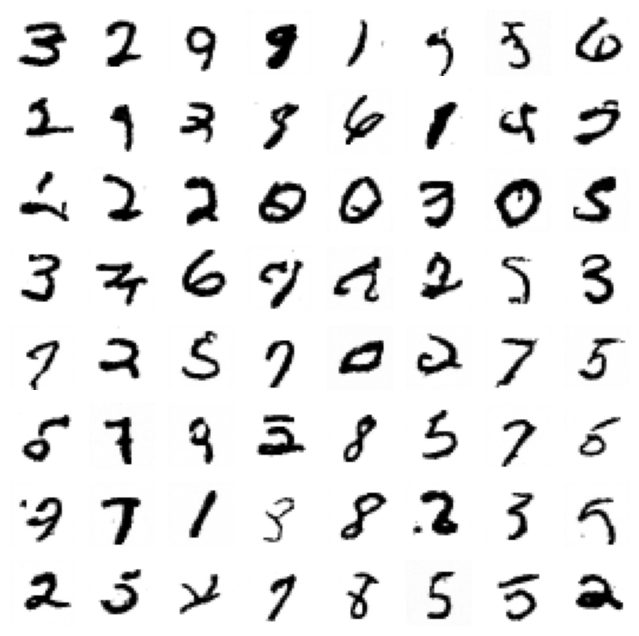

In [32]:
x0 = sample_prior()
plot_image_grid(x0.cpu());

In [12]:
# from image_diffusion.plotting_utils import to_imshow

# x0, y = sample_conditional()
# # plot_image_grid(x0.cpu());
# print(x0)
# fig, axes = plt.subplots(len(x0), 2, figsize=(4, 2*len(x0)))
# for i in range(len(x0)):
#     axes[i, 0].imshow(to_imshow(x0[i]))
#     likelihood.plot_condition(images[i], y[i], axes[i, 1])
#     axes[i, 0].axis('off'); axes[i, 1].axis('off');
# fig.tight_layout()

In [9]:
def train(num_epochs=25, lr=1e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    num_batches = len(train_loader)
    for e in range(num_epochs):
        pbar = tqdm.tqdm(total=num_batches)
        for i, (X, _) in enumerate(train_loader):
            X = X.to(device)
            opt.zero_grad()
            loss_value = loss_fn(X)
            loss_value.backward()
            opt.step()
            losses.append(loss_value.item())
            pbar.update(1)
        print(f"Epoch {e} - {np.mean(losses[-100:]):.2f}")

    torch.save(model.state_dict(), 'model_weights.pth')
    return losses

# losses = train()
# plt.plot(losses)
# plt.savefig("loss.png")
# exit(0)

99 1.0 0.9898989796638489
98 0.9898989796638489 0.9797979593276978
97 0.9797979593276978 0.9696969985961914
96 0.9696969985961914 0.9595959782600403
95 0.9595959782600403 0.9494949579238892
94 0.9494949579238892 0.939393937587738
93 0.939393937587738 0.9292929172515869
92 0.9292929172515869 0.9191918969154358
91 0.9191918969154358 0.9090909361839294
90 0.9090909361839294 0.8989899158477783
89 0.8989899158477783 0.8888888955116272
88 0.8888888955116272 0.8787878751754761
87 0.8787878751754761 0.868686854839325
86 0.868686854839325 0.8585858345031738
85 0.8585858345031738 0.8484848737716675
84 0.8484848737716675 0.8383838534355164
83 0.8383838534355164 0.8282828330993652
82 0.8282828330993652 0.8181818127632141
81 0.8181818127632141 0.808080792427063
80 0.808080792427063 0.7979797720909119
79 0.7979797720909119 0.7878788113594055
78 0.7878788113594055 0.7777777910232544
77 0.7777777910232544 0.7676767706871033
76 0.7676767706871033 0.7575757503509521
75 0.7575757503509521 0.7474747300148

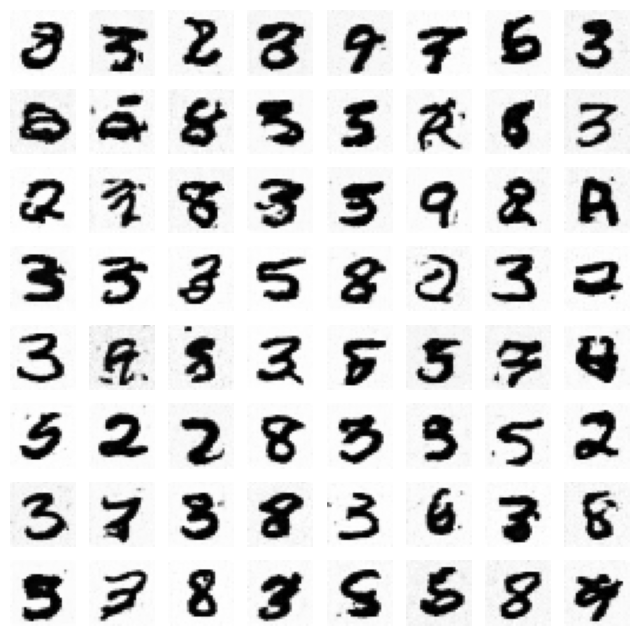

In [37]:
from image_diffusion.sampling import heun_integrate_loop, unsqueeze_like
from image_diffusion.sde_diffusion import extract

score_fn = diffusion.get_score_fn(eps_model, conditioning)
ts = torch.linspace(diffusion.tmax, diffusion.tmin, diffusion.Ns).to(device)


@torch.inference_mode()
def euler_maruyama_integrate_loop(drift, diffusion, x0, ts):
    """Integrate diffusion SDE with euler maruyama integrator."""

    t12s = torch.stack([ts[:-1], ts[1:]], -1)

    x = x0
    traj = [x]
    for j, (t1, t2) in enumerate(t12s):
        i = len(ts) - j - 1
        print(i, t1.item(), t2.item())
        t1_ = t1 * torch.ones((len(x),), device=x.device)
        f = drift(x, t1_)
        if i > 1: # NOTE: do not add noise in the last step
            noise = torch.randn_like(x0)
        else:
            noise = torch.zeros_like(x0)
        g = unsqueeze_like(noise, diffusion(t1))
        x = x + (t2 - t1) * f + g * noise * torch.sqrt(torch.abs(t1 - t2))
        if x.isnan().any():
            raise ValueError(f"NaN encountered in trajectory during {t1} -> {t2}")
        traj.append(x)

    return x, torch.stack(traj)

# Reverse solve Probability Flow
x, xs = euler_maruyama_integrate_loop(
    drift=lambda x, t: diffusion.backward_drift(score_fn, x, t),
    diffusion=diffusion.backward_diffusion,
    x0=torch.randn_like(images),
    ts=ts
)
# x, xs = heun_integrate_loop(
#     dynamics=lambda x, t: diffusion.backward_dynamics(score_fn, x, t),
#     x0=torch.randn_like(images),
#     ts=ts
# )
plot_image_grid(x.cpu());

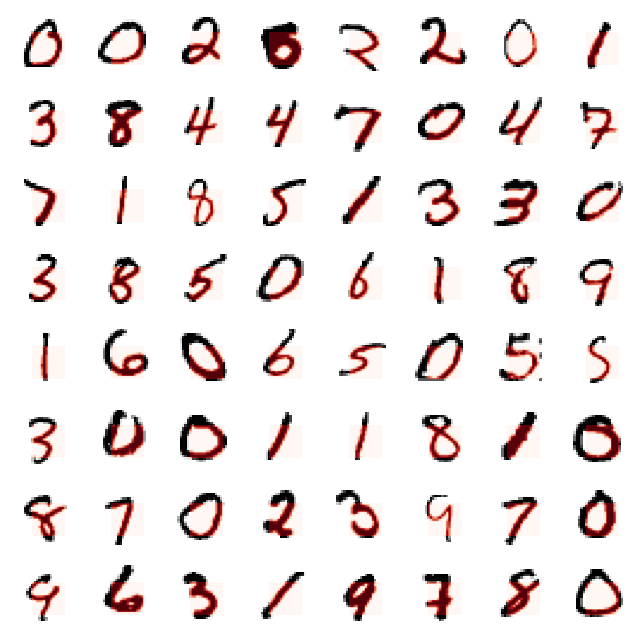

In [38]:

IMAGE_WIDTH = IMAGE_HEIGHT = 28
PATCH_HEIGHT = PATCH_WIDTH = 15

def get_random_patch_slices(H=IMAGE_HEIGHT, W=IMAGE_WIDTH, h=PATCH_HEIGHT, w=PATCH_WIDTH):
    """
    Get random slice object to extract a patch of size [h, w]
    from an image assuming CHW ordering.
    """
    h_start = np.random.randint(0, H - h + 1)
    w_start = np.random.randint(0, W - w + 1)
    return np.s_[:, h_start:h_start+h, w_start:w_start+w]


patch_slice = get_random_patch_slices()
patches = images[(np.s_[:], *patch_slice)]
plot_image_grid(images, patches, patch_slice);

In [39]:

from image_diffusion.sde_diffusion import unsqueeze_like

# @torch.inference_mode()
def conditioned_scores(
        xt: torch.Tensor, t, y, slice_, alpha=10, overwrite_observed_score: bool = True,
    ):
    """
    xt: [N, C, H, W]
    t: [N]
    y: [N, C, h, w], in our case these will be patches
    slice_: the following must hold
        xt[:, slice_].shape == y.shape
    """
    x0_model = diffusion.get_x0_model(eps_model, conditioning)
    
    def constraint(x, t, y):
        x = x.unsqueeze(0)  # [1, ...]
        t = t.unsqueeze(0)  # [1,]
        # x0 = diffusion.denoise_input(score_fn, x, t)[0]  # [C, H, W]
        i = (t * (diffusion.Ns - 1))  # [0, ..., Ns-]
        x0 = x0_model(x, i.type(torch.int64))
        # x0 = x0_model(x, t)  # [C, H, W]
        # sliced = x0[slice_]  # [C, h, w]
        sliced = x0.squeeze(0)[slice_]  # [C, h, w]
        return torch.sum((sliced - y)**2)  # []
    
    # approximating p_{0t}
    mean_scale = diffusion.scale(t)  # [N,]
    sigma = diffusion.sigma(t)  # [N,]
    # sigma += 1e-6
    scale = alpha * mean_scale**2 / sigma ** 2  # [N,]
    scale = unsqueeze_like(xt, scale)  # [N, ...]

    xt_ = xt.detach().clone().requires_grad_()
    score_observed = vmap(grad(constraint, argnums=(0)))(xt_, t, y)  # [N, ...]
    score = score_fn(xt, t) - scale * score_observed  # [N, ...]

    if overwrite_observed_score:
        # replace score at observed indices by 'true' score,
        # which can be calculated as we have access to the true
        # values at t=0.
        yt = xt[(np.s_[:], *slice_)]
        observed_score = diffusion.noise_score(yt, y, t)  # [N, C, h, w]
        score[(np.s_[:], *slice_)] = observed_score
    return score


def conditional_sample(alpha, overwrite_observed_score):
    cond_score_fn = lambda x, t: conditioned_scores(x, t, patches, patch_slice, alpha=alpha, overwrite_observed_score=overwrite_observed_score)
    x, _ = euler_maruyama_integrate_loop(
        drift=lambda x, t: diffusion.backward_drift(cond_score_fn, x, t),
        diffusion=diffusion.backward_diffusion,
        # diffusion=lambda *args: 0.0,
        x0=torch.randn_like(images),
        ts=ts
    )
    return x


In [69]:

# @torch.no_grad()
# def p_sample(x0_model, x, i: int, y, slice_, alpha):
#     def constraint(x, i, y):
#         x = x.unsqueeze(0)  # [1, ...]
#         i = i.unsqueeze(0)  # [1,]
#         x0 = x0_model(x, i)
#         sliced = x0.squeeze(0)[slice_]  # [C, h, w]
#         return torch.sum((sliced - y)**2)  # []
     
#     b, *_, device = *x.shape, x.device
#     batched_times = torch.full((b,), i, device=x.device, dtype=torch.long)
#     if y is not None and i < 125:
#         # approximating p_{0t}
#         x_ = x.detach().clone().requires_grad_()
#         idx = i * torch.ones(x.shape[0], dtype=torch.int64, device=x.device)
#         x_grad = vmap(grad(constraint, argnums=(0)))(x_, idx, y)  # [N, ...]

#         # Computing scaling as in continuous setting
#         # NOTE: not matching...
#         ts = torch.linspace(diffusion.tmin, diffusion.tmax, diffusion.Ns).to(device)
#         t1 = ts[i]
#         gamma = ts[-1] - ts[-2]
#         # print(i, t1.item())
#         t1_ = t1# * torch.ones((len(x),), device=x.device)
#         mean_scale = diffusion.scale(t1_)  # [N,]
#         sigma = diffusion.sigma(t1_)  # [N,]
#         # sigma += 1e-6
#         scale = alpha * mean_scale**2 / sigma ** 2  # [N,]
#         scale = unsqueeze_like(x, scale)  # [N, ...]
#         scale = gamma * scale
#         # print("scale1", scale.item())

#         # Computing scaling as in protein motif-scaffolding
#         a = diffusion.alphas[i]
#         scale = alpha * a * (1 - a)
#         # print("scale2", scale.item())
#         x_update = - scale * x_grad
#         x += x_update

#     model_mean, variance, model_log_variance, x_start = diffusion.p_mean_variance(x0_model, x=x, i=batched_times)
#     noise = torch.randn_like(x) if i > 0 else 0.0  # no noise if t == 0
#     pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
#     return pred_img, x_start

# @torch.no_grad()
# def p_sample_loop(x0_model, xN, y=None, slice_=None, alpha=10):
#     xi = xN
#     xs = [xi]
#     for i in reversed(range(diffusion.Ns)):
#         xi, _ = p_sample(x0_model, xi, i, y, slice_, alpha)
#         xs.append(xi)

#     return xi

def conditional_sample2(alpha, overwrite_observed_score):
    x0_model = diffusion.get_x0_model(eps_model, conditioning)
    xN = torch.randn_like(images)
    # x0 = p_sample_loop(x0_model, xN, patches, patch_slice, alpha)
    x0 = diffusion.p_sample_loop(x0_model, xN, patches, patch_slice, alpha)
    return x0


## Overwriting the observed score

In the conditional score we replace the score at the observed indices with the 'true' score.

/homes/ebm32/protein-diffusion/venv/lib/python3.9/site-packages/torch/_functorch/deprecated.py:62: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.grad instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('grad')
/homes/ebm32/protein-diffusion/venv/lib/python3.9/site-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torc

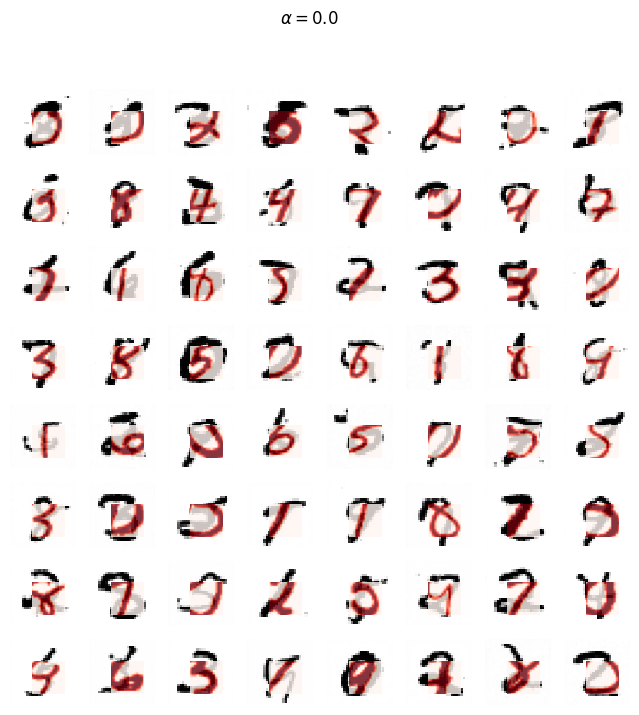

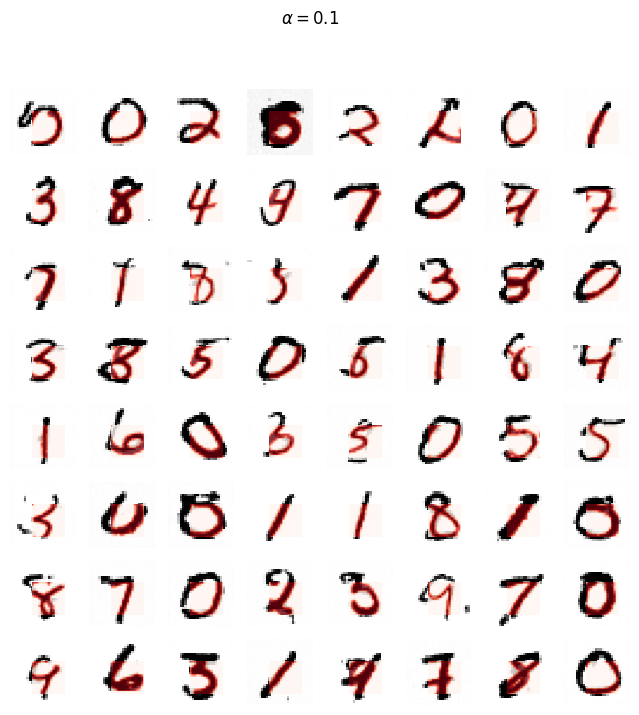

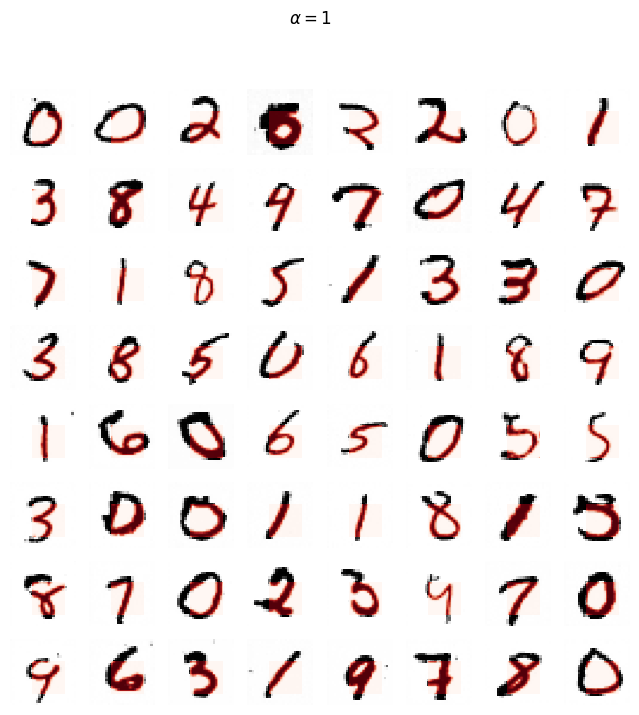

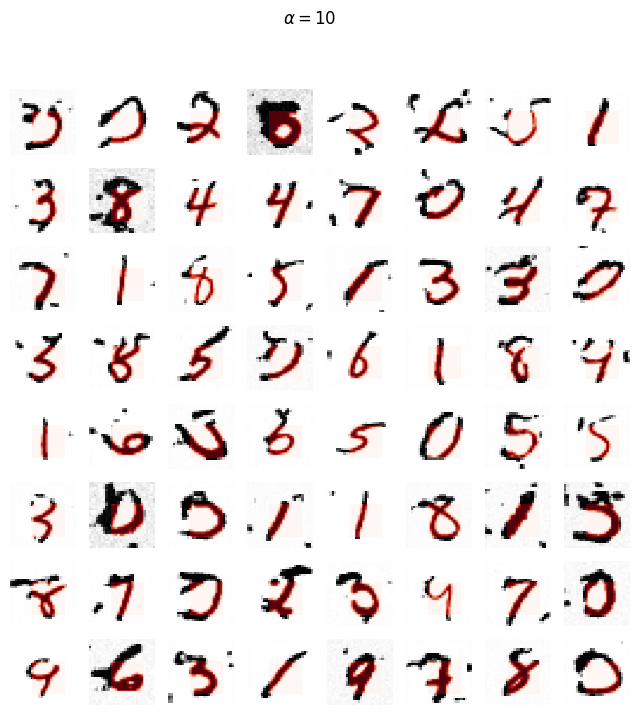

In [70]:
for alpha in [0.0, 0.1, 1, 10]:
# for alpha in [1]:
    # samples = conditional_sample(alpha, overwrite_observed_score=True)
    samples = conditional_sample2(alpha, overwrite_observed_score=True)
    fig, _ = plot_image_grid(samples, patches, patch_slice)
    fig.suptitle(f"$\\alpha={alpha}$");

## 'Pure' reconstruction guidance

following Finzi et al.

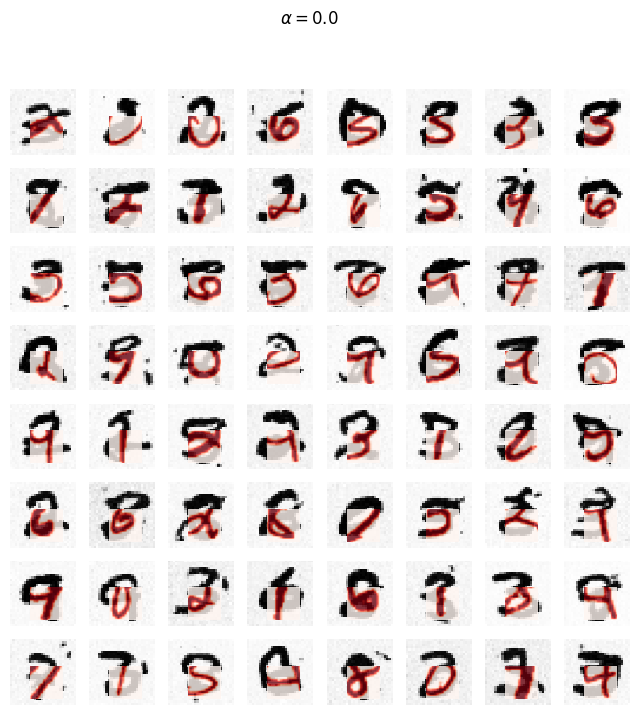

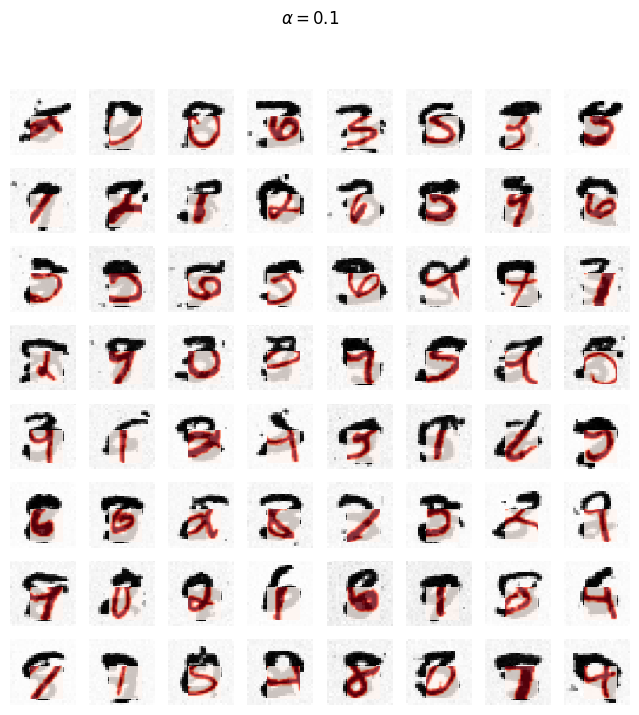

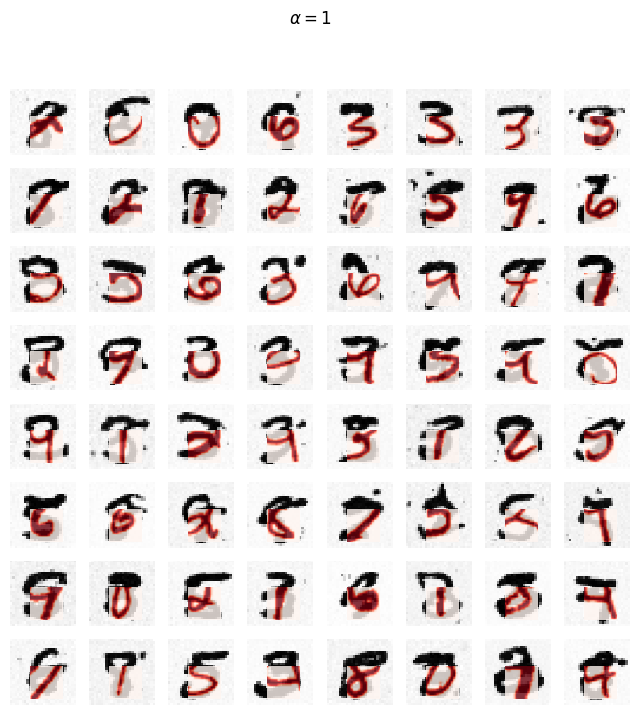

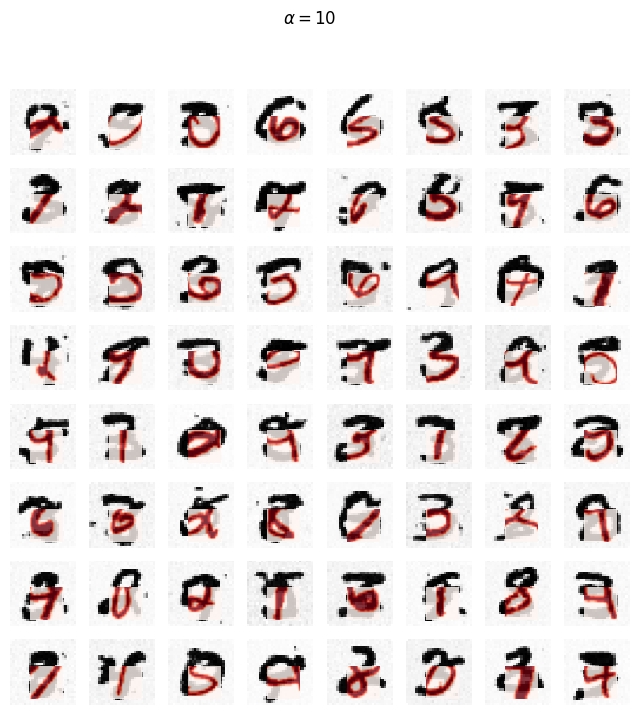

In [50]:
for alpha in [0.0, 0.1, 1, 10]:
    samples = conditional_sample(alpha, overwrite_observed_score=False)
    fig, _ = plot_image_grid(samples, patches, patch_slice)
    fig.suptitle(f"$\\alpha={alpha}$");